# Import libs

In [1]:
import gym


import matplotlib.pyplot as plt
import seaborn as sns

import math
import random
import numpy as np

from tqdm.notebook import tqdm_notebook
from copy import deepcopy


from collections import namedtuple

from itertools import count



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


from tic_tac_toe import TicTacToe

%reload_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
%matplotlib inline

# Task 1 

## крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

    1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
    2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
    
**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

### Field 3 x 3

In [4]:
env = TicTacToe()

In [2]:
def e_greedy(env, Q, epsilon = 0.01):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    if env.getState()[0] not in Q.keys():
        Q[env.getState()[0]] = np.zeros(len(possible_actions))
        
    if np.random.random() > epsilon:
        return np.argmax(Q[env.getState()[0]]), possible_actions[np.argmax(Q[env.getState()[0]])]
    else:
        ch = np.random.choice(len(possible_actions))
        return ch, possible_actions[ch]

In [3]:
LR = 0.01
GAMMA = 1.

def Q_learning_one_game(strategy, 
                        env, 
                        Q, 
                        lr = LR, 
                        gamma = GAMMA, 
                        crosses = 1, 
                        *args, **kwargs):
    env.reset()
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
        
    while True:
        
        state = env.getState()[0]

        
        q_action, action = strategy(env, Q, *args, **kwargs)

            
        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            
            return reward

            
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            
            
        next_state_, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            
            return reward
            
        next_state = next_state_[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            Q[next_state] = np.zeros(len(possible_actions))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
            

In [4]:
def run_many_games_Q_learning(strategy, env = TicTacToe(), n_games = 100000, verbose = True, print_every = 1000, crosses = 1, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = {}
    for i in tqdm_notebook(range(n_games)):
        R = Q_learning_one_game(strategy, env, Q, crosses = crosses, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " средняя награда: {}".format(np.mean(avg_every)))
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

In [15]:
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, verbose = False, crosses = -1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

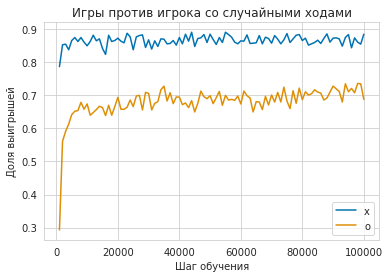

In [16]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'x')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'o')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

### Field 4 x 4

In [17]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, 
                                                                  env = env, 
                                                                  n_games = 100000, 
                                                                  verbose = False, 
                                                                  crosses = 1)

Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, 
                                                              env = env, 
                                                              n_games = 100000, 
                                                              verbose = False, 
                                                              crosses = -1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

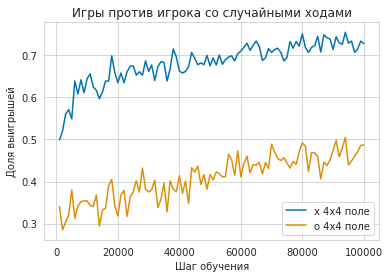

In [19]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'x 4x4 поле')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'o 4x4 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

### Field 5 x 5

In [20]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WIN)

Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, 
                                                                  env = env, 
                                                                  n_games = 100000, 
                                                                  verbose = False, 
                                                                  crosses = 1)

Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, 
                                                              env = env, 
                                                              n_games = 100000, 
                                                              verbose = False, 
                                                              crosses = -1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

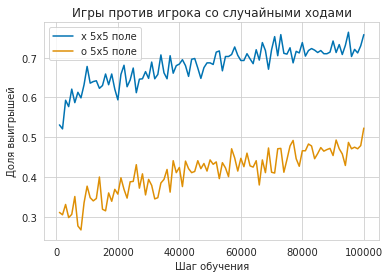

In [22]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'x 5x5 поле')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'o 5x5 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

# Task 2

## добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

    1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего,           experience replay потребуется сразу же.
    2. Реализуйте Double DQN и/или Dueling DQN.

In [5]:
Capcity = 10000
N_games = 10000
n_chanels = 9
batch_size = 64
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
from DQN import DQN, DQN_noughts

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
def e_greedy_dqn(env, dqn, epsilon = 0.01, device = device):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    fstate = torch.Tensor(env.board)
    actions = dqn(fstate.unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).cpu().detach().numpy()
    #print(possible_actions)
    Q_actions = actions[possible_actions] 
    #print(epsilon)
    if np.random.random() > epsilon:
        return possible_actions[np.argmax(Q_actions)]
    else:
        return np.random.choice(possible_actions)

In [9]:
def dqn_learn(dqn, memory, optimizer, gamma):
    batch = memory.sample(batch_size)
    
    fstate_batch = [el[0] for el in batch]
    
    actions = np.array([el[1] for el in batch])
    
    fnext_state_batch = [el[2][0] for el in batch]
    isTermanal = [el[2][1] for el in batch]
    fnext_actions = [el[2][2] for el in batch]
    
    reward = np.array([el[3] for el in batch])
    
    with torch.no_grad():
        predictions = dqn(torch.Tensor(fnext_state_batch).unsqueeze(1).to(device)).cpu().detach().numpy()
        predicted_target = gamma * np.array(
            [np.max(predictions[i][fnext_actions[i]]) if fnext_actions[i] != [] else 0. for i in range(batch_size)])
        predicted_target += reward
        target = torch.Tensor([reward[i] if isTermanal[i] else predicted_target[i] for i in range(batch_size)])
    
    predictions = dqn(torch.Tensor(fstate_batch).unsqueeze(1).to(device)).cpu().squeeze()

    loss = F.mse_loss(predictions[np.arange(batch_size), actions], target)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [10]:
def DQN_train_episode(env, NN, optimizer, memory, gamma = 1., crosses = 1, Capcity = Capcity, device = device, *args, **kwargs):
    env.reset()
    
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    loss = 0.
    
    while True:

        fstate = env.board
        fstate_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        
        action = e_greedy_dqn(env, NN, *args, **kwargs)

        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss

        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            

        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss
        else:
            fnext_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            memory.push(fstate, action, (env.board, not done, fnext_actions), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)

In [11]:
def DQN_train(env, NN, N_games = N_games, gamma = 1., crosses = 1, Capcity = Capcity, device = device, verbose = True, print_every = 1000,  *args, **kwargs):
    memory = ReplayMemory(Capcity)
    optimizer = optim.Adam(NN.parameters(), 0.01)
    
    mean_game_rewards = []
    mean_game_loss = []
    avg_every = []
    loss_every = []
    epsilon = 1.
    for i in tqdm_notebook(range(N_games)):
        if i % 1000 == 999:
            epsilon = epsilon - 0.1
            epsilon = max(0.01, epsilon)
            
        R, loss = DQN_train_episode(env, NN, optimizer, memory, gamma, crosses, Capcity, device, epsilon= epsilon,*args, **kwargs)
        avg_every.append(R)
        loss_every.append(loss)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, N_games) + " средняя награда: {}".format(np.mean(avg_every)) + ' loss: {}'.format(np.mean(loss_every)))
            mean_game_rewards.append(np.mean(avg_every))
            mean_game_loss.append(np.mean(loss_every))
            avg_every = []
            loss_every = []
    return NN, mean_game_rewards

## Поле 3x3x3

In [24]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: 0.302 loss: 0.6486224440410733
2000/10000 средняя награда: 0.253 loss: 0.65298202303797
3000/10000 средняя награда: 0.301 loss: 0.6727138581499458
4000/10000 средняя награда: 0.383 loss: 0.6731553456932307
5000/10000 средняя награда: 0.447 loss: 0.667372859492898
6000/10000 средняя награда: 0.459 loss: 0.6499378745704889
7000/10000 средняя награда: 0.519 loss: 0.644216894544661
8000/10000 средняя награда: 0.578 loss: 0.6214305344522
9000/10000 средняя награда: 0.693 loss: 0.6067255467027426
10000/10000 средняя награда: 0.727 loss: 0.6051529905498028


In [25]:

NN_noughts = DQN_noughts(env.n_cols, 64).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.282 loss: 0.4094306162726134
2000/10000 средняя награда: -0.232 loss: 0.5580259531438351
3000/10000 средняя награда: -0.202 loss: 0.5790978664234281
4000/10000 средняя награда: -0.141 loss: 0.5918115236759186
5000/10000 средняя награда: -0.067 loss: 0.5682557141780853
6000/10000 средняя награда: -0.003 loss: 0.5384558214768768
7000/10000 средняя награда: 0.007 loss: 0.5071703335866332
8000/10000 средняя награда: 0.09 loss: 0.4797732244208455
9000/10000 средняя награда: 0.095 loss: 0.43193028812482953
10000/10000 средняя награда: 0.122 loss: 0.3663834119699895


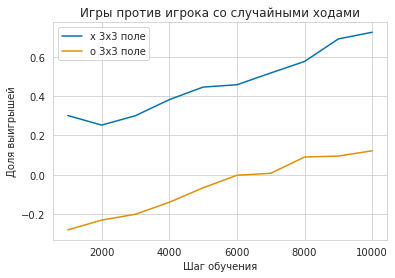

In [28]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 3x3 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 3x3 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend()

## Поле 4x4x4 

In [29]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.038 loss: 0.5436469127889723
2000/10000 средняя награда: 0.104 loss: 0.6042799166338518
3000/10000 средняя награда: 0.086 loss: 0.5981243469202892
4000/10000 средняя награда: 0.084 loss: 0.5890109919626266
5000/10000 средняя награда: 0.171 loss: 0.6046859338115901
6000/10000 средняя награда: 0.221 loss: 0.6165616437001153
7000/10000 средняя награда: 0.253 loss: 0.6415489838477224
8000/10000 средняя награда: 0.344 loss: 0.6351877152901143
9000/10000 средняя награда: 0.386 loss: 0.6512718381416053
10000/10000 средняя награда: 0.513 loss: 0.6420244537908584


In [30]:

NN_noughts = DQN_noughts(env.n_cols, 128).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.054 loss: 0.24191524264309555
2000/10000 средняя награда: -0.037 loss: 0.44039612719090654
3000/10000 средняя награда: -0.008 loss: 0.45347688330011443
4000/10000 средняя награда: -0.004 loss: 0.4661152412197553
5000/10000 средняя награда: -0.023 loss: 0.47660419581457975
6000/10000 средняя награда: -0.009 loss: 0.4882596419285983
7000/10000 средняя награда: -0.013 loss: 0.4775818660352379
8000/10000 средняя награда: 0.041 loss: 0.45000068193674087
9000/10000 средняя награда: 0.204 loss: 0.5014622507942841
10000/10000 средняя награда: 0.283 loss: 0.5040361042078585


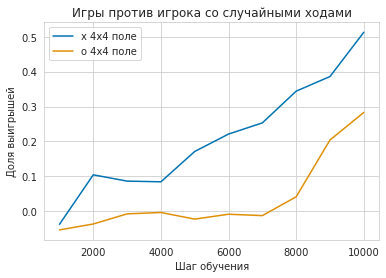

In [31]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 4x4 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 4x4 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend()

## Поле 5x5x5 

In [32]:
N_ROWS, N_COLS, N_WIN = 5,5,5

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: 0.103 loss: 0.49403290934627875
2000/10000 средняя награда: 0.104 loss: 0.5589349873745814
3000/10000 средняя награда: 0.141 loss: 0.5809131726808846
4000/10000 средняя награда: 0.121 loss: 0.5911447761664167
5000/10000 средняя награда: 0.143 loss: 0.5886913788560778
6000/10000 средняя награда: 0.169 loss: 0.5952055090535432
7000/10000 средняя награда: 0.197 loss: 0.6181815266800113
8000/10000 средняя награда: 0.276 loss: 0.6376784077705815
9000/10000 средняя награда: 0.279 loss: 0.6273281706189737
10000/10000 средняя награда: 0.374 loss: 0.6562768976930529


In [33]:

NN_noughts = DQN_noughts(env.n_cols, 256).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.075 loss: 0.2312966230188904
2000/10000 средняя награда: -0.084 loss: 0.37094391144478867
3000/10000 средняя награда: -0.056 loss: 0.38069021804613296
4000/10000 средняя награда: -0.058 loss: 0.42004941665440854
5000/10000 средняя награда: -0.094 loss: 0.4119632355223439
6000/10000 средняя награда: -0.002 loss: 0.4276356411587185
7000/10000 средняя награда: 0.08 loss: 0.42689514728344513
8000/10000 средняя награда: 0.153 loss: 0.4328260531203705
9000/10000 средняя награда: 0.312 loss: 0.5054558726118994
10000/10000 средняя награда: 0.426 loss: 0.5753039950458333


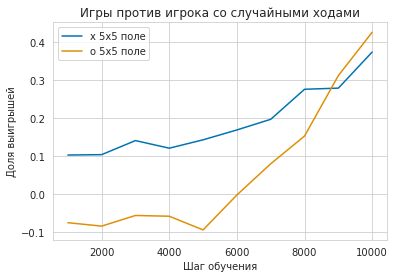

In [35]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 5x5 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 5x5 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

## Dueling DQN 

In [36]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DuelingDQN, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
        self.l2 = nn.Linear(self.n_chanels, 1)
    def forward(self, x):
        x = torch.tanh(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        

        z = self.l(x)

        y = self.l2(x)
        ma =  torch.mean(z, dim=1, keepdim=True)

        return z + y - ma

In [37]:
N_ROWS, N_COLS, N_WIN = 3,3,3

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: 0.267 loss: 0.5258839418664575
2000/10000 средняя награда: 0.314 loss: 0.6309869500920177
3000/10000 средняя награда: 0.364 loss: 0.6440383608341217
4000/10000 средняя награда: 0.423 loss: 0.6502936293557287
5000/10000 средняя награда: 0.397 loss: 0.6511019705384969
6000/10000 средняя награда: 0.458 loss: 0.6322915541827678
7000/10000 средняя награда: 0.438 loss: 0.603042608320713
8000/10000 средняя награда: 0.463 loss: 0.5705676930248738
9000/10000 средняя награда: 0.503 loss: 0.546603781118989
10000/10000 средняя награда: 0.601 loss: 0.5923552105128765


In [41]:

NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.313 loss: 0.4767444503456354
2000/10000 средняя награда: -0.26 loss: 0.6216730852723121
3000/10000 средняя награда: -0.265 loss: 0.6423367734625935
4000/10000 средняя награда: -0.198 loss: 0.6340820740088821
5000/10000 средняя награда: -0.278 loss: 0.629413695603609
6000/10000 средняя награда: -0.308 loss: 0.616542564675212
7000/10000 средняя награда: -0.154 loss: 0.6107961903214455
8000/10000 средняя награда: -0.197 loss: 0.588397825345397
9000/10000 средняя награда: -0.2 loss: 0.599630293160677
10000/10000 средняя награда: -0.146 loss: 0.5772876876294613


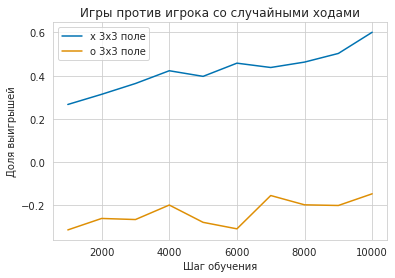

In [43]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 3x3 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 3x3 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

In [44]:
env = TicTacToe(4,4,4)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: 0.011 loss: 0.4572445175885223
2000/10000 средняя награда: 0.1 loss: 0.5729173790803179
3000/10000 средняя награда: 0.046 loss: 0.5698997140480205
4000/10000 средняя награда: 0.093 loss: 0.5993367598606274
5000/10000 средняя награда: 0.138 loss: 0.6019398034317419
6000/10000 средняя награда: 0.108 loss: 0.6085342444842682
7000/10000 средняя награда: 0.177 loss: 0.6147387215457857
8000/10000 средняя награда: 0.234 loss: 0.6295020334543661
9000/10000 средняя награда: 0.101 loss: 0.6316123679289595
10000/10000 средняя награда: 0.097 loss: 0.5648363993819803


In [45]:
env = TicTacToe(4,4,4)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.028 loss: 0.43484412641916426
2000/10000 средняя награда: -0.032 loss: 0.5740753700435162
3000/10000 средняя награда: -0.045 loss: 0.5610303767966106
4000/10000 средняя награда: -0.013 loss: 0.5821138524264097
5000/10000 средняя награда: 0.022 loss: 0.613598571728915
6000/10000 средняя награда: 0.104 loss: 0.5961378635941074
7000/10000 средняя награда: 0.125 loss: 0.5819693845920265
8000/10000 средняя награда: 0.175 loss: 0.5716701140962541
9000/10000 средняя награда: 0.306 loss: 0.5313067739456891
10000/10000 средняя награда: 0.205 loss: 0.5328191100703552


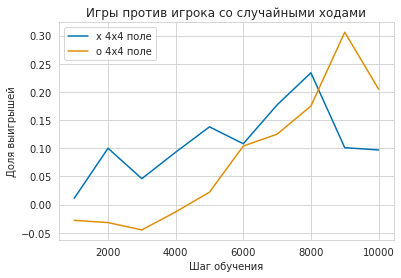

In [46]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 4x4 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 4x4 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

In [47]:
env = TicTacToe(5,5,5)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: 0.079 loss: 0.37094674350065177
2000/10000 средняя награда: 0.059 loss: 0.4326708289787639
3000/10000 средняя награда: 0.067 loss: 0.4464451170465909
4000/10000 средняя награда: 0.084 loss: 0.4418828848297708
5000/10000 средняя награда: 0.155 loss: 0.46314234658447095
6000/10000 средняя награда: 0.086 loss: 0.47123598082759416
7000/10000 средняя награда: 0.136 loss: 0.47910367378476076
8000/10000 средняя награда: 0.226 loss: 0.5270159668498673
9000/10000 средняя награда: 0.269 loss: 0.513514640283538
10000/10000 средняя награда: 0.27 loss: 0.49374396304530094


In [48]:

NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 средняя награда: -0.108 loss: 0.3869594771157717
2000/10000 средняя награда: -0.111 loss: 0.42911702625430187
3000/10000 средняя награда: -0.113 loss: 0.448773420709651
4000/10000 средняя награда: -0.083 loss: 0.4495966583581176
5000/10000 средняя награда: -0.07 loss: 0.4639938054033555
6000/10000 средняя награда: -0.089 loss: 0.4368739061418455
7000/10000 средняя награда: -0.069 loss: 0.4706618945293594
8000/10000 средняя награда: -0.071 loss: 0.44163957898295486
9000/10000 средняя награда: -0.095 loss: 0.4577581708165817
10000/10000 средняя награда: -0.087 loss: 0.42557881633774375


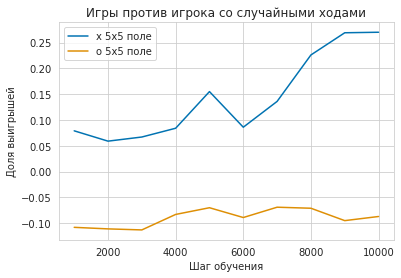

In [49]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'х 5x5 поле')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'о 5x5 поле')
plt.xlabel('Шаг обучения')
plt.ylabel('Доля выигрышей')
plt.title("Игры против игрока со случайными ходами")
plt.legend();

# Task 3

## расширим и углубим поиск

Крестики-нолики - это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

        1. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой             стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас           получилась в первом пункте).
        2. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните           полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

## Rollouts 

In [50]:
def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    rewards = {el: [] for el in possible_actions}
    for i in range(nrolls):
        for act in possible_actions:
            cur_env = deepcopy(env)
            _, reward, done, _ = cur_env.step(cur_env.action_from_int(act))
            if done:
                rewards[act].append(reward * crosses)
                continue
                
            while True:
                #opponents turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                opponents_action = np.random.choice(p_actions)
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                
                #our turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                our_action = strategy(cur_env, *args, **kwargs)
                
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                    
    actions = {el: np.mean(rewards[el]) for el in possible_actions}
    maxi = -10
    max_act = 0
    for act in actions.keys():
        if actions[act] > maxi:
            max_act = act
            maxi = actions[act]
    return max_act, actions

In [51]:
def rollout_game(env, strategy, nrolls = 100, crosses = 1, *args, **kwargs):
    if crosses != env.curTurn:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    
    while True:
        #our turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        our_action, _ = rollout(env, strategy, nrolls, crosses, *args, **kwargs)
                
        _, reward, done, _ = env.step(env.action_from_int(our_action))
        
        if done:
            return reward * crosses
        
        #opponents turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        
        if done:
            return reward * crosses

In [52]:
def random_str(env):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    return possible_actions[np.random.choice(len(possible_actions))]

In [53]:
env = TicTacToe(3,3,3)
env.reset()

In [54]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100))
    
print(np.mean(rewards))

  0%|          | 0/100 [00:00<?, ?it/s]

0.99


In [55]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100, crosses = -1))
    
print(np.mean(rewards))

  0%|          | 0/100 [00:00<?, ?it/s]

0.84


In [56]:
env = TicTacToe(4,4,4)
env.reset()

In [57]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

1.0


In [58]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20, crosses = -1))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

0.9


In [59]:
env = TicTacToe(5,5,5)
env.reset()

In [60]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

0.9


In [61]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20, crosses = -1))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

0.9


## MCTS

In [62]:
def replace(s, position, character):
    return s[:position] + character + s[position+1:]

In [63]:
C = 0.8

class Node():
    def __init__(self):
        self.parent = None
        self.children = {}
        self.visits = 0
        self.value = 0
        self.state = None
        self.index = 0
        self.storage = None
    
    def ucb(self):
        if self.visits == 0:
            return float('inf')
        return self.value / self.visits + C * math.sqrt(math.log(self.storage[self.parent].visits) / self.visits)
    
    def create_children(self):
        if self.is_leaf():
            np_state = np.array(list(map(int, self.state)))
            available_actions = np.where(np_state == 1)[0]
            if (len(self.state) - len(available_actions)) % 2 == 0:
                curTurn = 1
            else:
                curTurn = -1
            for action in available_actions:
                child = Node()
                child.parent = self.index
                child.state = replace(self.state, action, str(curTurn + 1))
                child.index = len(self.storage)
                child.storage = self.storage
                self.children[action] = child.index
                self.storage.append(child)
    
    def is_leaf(self):
        return len(self.children) == 0
    
    def select_child(self, how="best"):
        eps = 0.7
        if how == "best":
            fun = max
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "worse":
            fun = min
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "random":
            return random.choice(list(self.children.items()))
        else:
            fun = None
            characteristic = None
        if not self.is_leaf():
            return max(self.children.items(), key=characteristic)

In [64]:
 def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    cur_env= deepcopy(env)
    done = env.gameOver
    if done:
        return 0 
    
    while True:
        #our turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        our_action = strategy(cur_env, *args, **kwargs)
                
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
        if done:
            return reward * crosses
        
        #opponents turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
        if done:
            return reward * crosses
                

In [65]:
class Mcts():
    def __init__(self, env, crosses = 1):
        self.env = env
        self.env.reset()
        self.crosses = crosses
        self.nodes = []

        root = Node()
        root.state = self.env.getState()[0]
        root.index = 0
        root.storage = self.nodes
        self.nodes.append(root)
        
        self.current_node = 0
        
    def next_step(self):
        action, self.current_node = self.nodes[self.current_node].select_child()
        self.env.step(self.env.action_from_int(action))
    
    def selection(self):
        while not self.nodes[self.current_node].is_leaf():
            self.next_step()
    
    def expansion(self):
        if not self.env.gameOver:
            if self.nodes[self.current_node].visits > 0:
                self.nodes[self.current_node].create_children()
                self.next_step()
    
    def simulation(self):
        return rollout(self.env, random_str, 1, self.crosses)
    
    def backpropagation(self, r):
        while self.nodes[self.current_node].parent is not None:
            self.nodes[self.current_node].visits += 1
            self.nodes[self.current_node].value += r
            self.current_node = self.nodes[self.current_node].parent
        self.nodes[self.current_node].visits += 1
        self.nodes[self.current_node].value += r
    
    def learn(self, n_episodes=10000):
        for _ in tqdm_notebook(range(n_episodes)):
            assert self.current_node == 0
            self.env.reset()
            self.selection()
            self.expansion()
            r = self.simulation()
            self.backpropagation(r)

In [69]:
def run(model, n_episodes = 12, crosses = 1):
    cum_rewards = 0
    count_games = 0
    for _ in range(n_episodes):
        model.env.reset()
        model.current_node = 0
        if crosses == 1:
            hows = [None, "best", "random"]
        elif crosses == -1:
            hows = [None, "random", "worse"]
        else:
            hows = None
        while not model.nodes[model.current_node].is_leaf():
            action, model.current_node = model.nodes[model.current_node].select_child(hows[model.env.curTurn])
            _, reward, done, _ = model.env.step(model.env.action_from_int(action))
        if done:
            cum_rewards += reward
            count_games += 1
    mean_reward = cum_rewards / count_games
    print(f"Средняя награда vs random policy = {mean_reward} после {count_games} игр.")
    return mean_reward

In [70]:
env = TicTacToe(3,3,3)

mcts = Mcts(env, 1000000)
mcts.learn()
run(mcts, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Средняя награда vs random policy = 0.7827368421052632 после 2375 игр.


0.7827368421052632

In [71]:
env = TicTacToe(4,4,4)

mcts = Mcts(env, 10000000)
mcts.learn()
run(mcts, 100000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Средняя награда vs random policy = 1.0 после 73 игр.


1.0